<a href="https://colab.research.google.com/github/danielhladky/CAS_ADS/blob/master/multiple_layer_network_TP_UniBE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

## Predictive Inventory Management

### Authors: Daniel Hladky and Vadim Peshekhonov

Integrum Solution AG works on specific customer projects. Within this work the aim is to predict the inventory based on the historical consumption of data. The data has been already extracted and cleaned and are available in a CSV format. The aim is to get 2 years of historical data and to train two models (e.g. LSTM and GradientBoosting) that will give a simple view of the stock movement. The regression will be implemented in Keras or TensorFlow and Scikit-Learn.

Links to datasets you may use: Customer specific historical data as CSV The data will be kind of anonymous. Only UUID (individual stock within supply chain is shown withut customer name)

Date: 19 February 2019 (project presentation at UniBE)

## Module 3 - UniBE - CAS Applied Data Science
For the module 3 we have elaborated on various aspects and created different notebooks within Colab or jupyter notebooks. 

### Part I   -  Data Analysis, XGB, Lasso, Ridge(Time_series_analysis_TP_UniBE.ipynb)
### Part II  -  TensorFlow (TF) LSTM  (BAG_TP_ML_DL_UniBE.ipynb)
### Part III -  TF single hidden layer (TP_single_hidden_layer_network_ipynb.ipynb)
### Part IV -  TF FullyConnected_MultiLayer(multiple_layer_network_TP_UniBE.ipynb)

# Using a Multiple Layer Network


We will illustrate how to use a Multiple Layer Network in TensorFlow


The multiple neural network layer we will create will be composed of three fully connected hidden layers, with node sizes 50, 25, and 5

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import os
import os.path
import random
import numpy as np
import random
import requests
from tensorflow.python.framework import ops
import pandas as pd

In [0]:
Thermoplan = pd.read_csv('Thermoplan_Mean_Agg_pushed.csv')
#column name to forecast - predict a UUID - provide 2-3 potential UUID's
column_name3 = 'CAC59BCDBE86370D840726487D717367'
column_name2 = '026CBAE094394E01A29914AF256DD413'
column_name1 = '8C5BBAAB7A213D69885122F2BF3E986C'
data = Thermoplan[column_name1].values

In [0]:
window_size = 8
x_vals = []
y_vals = []
    
i = 0
while (i + window_size) <= len(data)-1:
    x_vals.append(list(data[i:i+window_size]))
    y_vals.append(data[i+window_size])
    i += 1



In [0]:
x_vals=np.array(x_vals)
y_vals=np.array(y_vals)

## Train model


In [0]:
# reset the graph for new run
ops.reset_default_graph()

# Create graph session 
sess = tf.Session()

# set batch size for training
batch_size = 150

# make results reproducible
seed = 3
np.random.seed(seed)
tf.set_random_seed(seed)

# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [0]:
# Record training column max and min for scaling of non-training data
train_max = np.max(x_vals_train, axis=0)
train_min = np.min(x_vals_train, axis=0)

# Normalize by column (min-max norm to be between 0 and 1)
def normalize_cols(mat, max_vals, min_vals):
    return (mat - min_vals) / (max_vals - min_vals)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train, train_max, train_min))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test, train_max, train_min))

In [0]:
# Define Variable Functions (weights and bias)
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return(weight)
    

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return(bias)
    
    
# Create Placeholders
x_data = tf.placeholder(shape=[None, 8], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [0]:
# Create a fully connected layer:
def fully_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return(tf.nn.relu(layer))


#--------Create the first layer (50 hidden nodes)--------
weight_1 = init_weight(shape=[8, 25], st_dev=10.0)
bias_1 = init_bias(shape=[25], st_dev=10.0)
layer_1 = fully_connected(x_data, weight_1, bias_1)

#--------Create second layer (25 hidden nodes)--------
weight_2 = init_weight(shape=[25, 10], st_dev=10.0)
bias_2 = init_bias(shape=[10], st_dev=10.0)
layer_2 = fully_connected(layer_1, weight_2, bias_2)


#--------Create third layer (5 hidden nodes)--------
weight_3 = init_weight(shape=[10, 3], st_dev=10.0)
bias_3 = init_bias(shape=[3], st_dev=10.0)
layer_3 = fully_connected(layer_2, weight_3, bias_3)


#--------Create output layer (1 output value)--------
weight_4 = init_weight(shape=[3, 1], st_dev=10.0)
bias_4 = init_bias(shape=[1], st_dev=10.0)
final_output = fully_connected(layer_3, weight_4, bias_4)

# Declare loss function (L1)
loss = tf.reduce_mean(tf.abs(y_target - final_output))

# Declare optimizer
my_opt = tf.train.AdamOptimizer(0.025)
train_step = my_opt.minimize(loss)

In [0]:
# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
test_loss = []
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    test_temp_loss = sess.run(loss, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_loss.append(test_temp_loss)
    if (i+1) % 25 == 0:
        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_loss))

Generation: 25. Loss = 30220.754
Generation: 50. Loss = 10385.852
Generation: 75. Loss = 2836.1804
Generation: 100. Loss = 2331.0613
Generation: 125. Loss = 2165.952
Generation: 150. Loss = 2007.0436
Generation: 175. Loss = 1995.888
Generation: 200. Loss = 1763.2795
Generation: 225. Loss = 1607.3531
Generation: 250. Loss = 2009.6138
Generation: 275. Loss = 1676.3534
Generation: 300. Loss = 1611.5719
Generation: 325. Loss = 1754.219
Generation: 350. Loss = 1699.7028
Generation: 375. Loss = 1878.68
Generation: 400. Loss = 1699.497
Generation: 425. Loss = 1648.022
Generation: 450. Loss = 1766.862
Generation: 475. Loss = 1769.5991
Generation: 500. Loss = 1738.8895


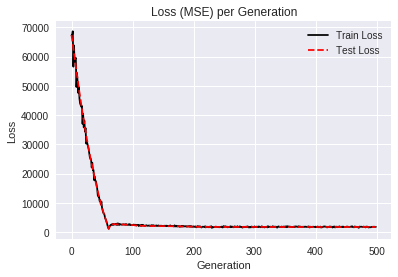

In [0]:
%matplotlib inline
# Plot loss (MSE) over time
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.legend(loc='upper right')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()